# Atividade 02: Implementando uma Rede Neural

Nesta atividade, você irá treinar uma rede neural com camadas completamente conectadas para realizar classificação de imagens, e irá testá-la utilizando o dataset CIFAR-10.

Nesta atividade, você irá:

- testar uma **função de perda** (**loss function**) para uma rede neural de duas camadas
- testar a avaliação de um **gradiente analítico**
- **verificar a implementação** utilizando gradiente numérico
- **treinar** uma rede em um pequeno problema por meio de **SGD**
- **treinar e depurar** uma rede em um conjunto de **dados reais**
- usar um conjunto de validação para **ajustar hiperparâmetros**
- **visualizar** os pesos finais que foram obtidos


## Preparação para usar o *Colaboratory*

Caso você deseje usar o *Colaborabory*, execute os comandos da célula a seguir para conseguir acessar os arquivos em uma conta do **Google Drive**.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Além disso, você talvez deseje trabalhar um subdiretório (ou pasta) específico, por exemplo `Pratica2`.  Esse diretório (ou pasta) já deve ter sido criado e conter o ***notebook*** dessa prática.

Sendo assim, utilize as instruções na próxima célula para alterar o diretório corrente para esse subdiretório (alterando o nome do subdiretório, se for o caso).

In [ ]:
import os
os.chdir("C:/Users/lucas/OneDrive/Documentos/Exercicio redes neurais")

FileNotFoundError: ignored

## Obtendo o conjunto de dados CIFAR-10

Nesta atividade, você irá desenvolver uma rede neural para realizar classificação de imagens e irá testá-la utilizando o dataset CIFAR-10. 

Para tando, você deve obter as imagens dessa base de dados executando a célula a seguir.

**OBS: Você só precisar realizar esta etapa uma vez!** Caso você já a tenha feito anteriormente e está retornando para continuar a execução dessa prática, não será necessário que se faça a recuperação das imagens novamente. Para verificar se os dados da base estão disponíveis, basta checar a existência do subdiretório `cifar-10-batches-py` no diretório corrente.

In [ ]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz

--2021-05-18 23:37:42--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  73.4MB/s    in 2.2s    

2021-05-18 23:37:45 (73.4 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


## Código de inicialização e configuração básica

Execute a célula a seguir para garantir a importação de alguns recursos básicos, bem como a inicialização/configuração para exibição correta de gráficos. 

In [ ]:
# Algum código de inicialização

import numpy as np
import matplotlib.pyplot as plt
from past.builtins import xrange

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%reload_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returna erro relativo """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Código para Classe implementando Rede Neural com 02 Camadas

Nesta atividade será utilizada a classe `TwoLayerNet`  para representar instâncias de uma rede neural. Esta classe se encontra definida dentro da célula abaixo .

Os parâmetros da rede serão armazenados na variável de instância `self.params` que é um dicionário em que as chaves são os nomes (*strings*) de cada parâmetro e os valores são **arrays numpy**.



In [ ]:
class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network. The net has an input dimension of
  N, a hidden layer dimension of H, and performs classification over C classes.
  We train the network with a softmax loss function and L2 regularization on the
  weight matrices. The network uses a ReLU nonlinearity after the first fully
  connected layer.

  In other words, the network has the following architecture:

  input - fully connected layer - ReLU - fully connected layer - softmax

  The outputs of the second fully-connected layer are the scores for each class.
  """

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    """
    Initialize the model. Weights are initialized to small random values and
    biases are initialized to zero. Weights and biases are stored in the
    variable self.params, which is a dictionary with the following keys:

    W1: First layer weights; has shape (D, H)
    b1: First layer biases; has shape (H,)
    W2: Second layer weights; has shape (H, C)
    b2: Second layer biases; has shape (C,)

    Inputs:
    - input_size: The dimension D of the input data.
    - hidden_size: The number of neurons H in the hidden layer.
    - output_size: The number of classes C.
    """
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    """
    Compute the loss and gradients for a two layer fully connected neural
    network.

    Inputs:
    - X: Input data of shape (N, D). Each X[i] is a training sample.
    - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] < C. This parameter is optional; if it
      is not passed then we only return scores, and if it is passed then we
      instead return the loss and gradients.
    - reg: Regularization strength.

    Returns:
    If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
    the score for class c on input X[i].

    If y is not None, instead return a tuple of:
    - loss: Loss (data loss and regularization loss) for this batch of training
      samples.
    - grads: Dictionary mapping parameter names to gradients of those parameters
      with respect to the loss function; has the same keys as self.params.
    """
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass

    layer1 = X.dot(W1) + b1      # Forward 1st layer
    layer1[layer1<0] = 0         # ReLU
    layer2 = layer1.dot(W2) + b2 # Forward 2nd layer
    scores = layer2 # This seems correct, but maybe check why ReLU only on first layer
    
    # If the targets are not given then jump out, we're done
    if y is None:
      return scores

    # Compute the loss
    loss = None

    # N is the Number of samples in training batch
    maxScores = scores.max()
    fj = (scores - maxScores).T      # normalize Scores
    fyi = fj[y,range(N)]             # correct scores

    # Li = -np.log( np.exp(fyi)/np.sum(np.exp(fj), axis=0))
    # or alternatively -- equivalent expressions
    Li = -fyi + np.log(np.sum(np.exp(fj), axis=0))

    mu_Li = np.mean( Li )                               # dataLoss
    RW = 0.5 * reg * (np.sum(W1*W1) + np.sum(W2*W2))    # regLoss

    loss = mu_Li + RW

    # Backward pass: compute gradients
    grads = {}

    dfj = (np.exp(fj)/np.sum(np.exp(fj), axis = 0)).T
    dfyi = np.zeros(fj.shape)
    dfyi[y,range(N)] = 1

    dfj = (np.exp(fj)/np.sum(np.exp(fj), axis = 0))
    dLi = (dfj - dfyi)/N

    db2 = dLi.sum(axis=1)
    dW2 = dLi.dot(layer1).T + reg*W2

    dLayer1 = dLi.T.dot(W2.T)
    dLayer1[layer1<=0] = 0

    db1 = dLayer1.sum(axis=0)
    dW1 = dLayer1.T.dot(X).T + reg*W1

    assert db2.shape==b2.shape
    assert dW2.shape==W2.shape
    assert db1.shape==b1.shape
    assert dW1.shape==W1.shape

    grads = {
        'b2': db2,
        'W2': dW2,
        'b1': db1,
        'W1': dW1
    }

    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=5e-6, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this neural network using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) giving training data.
    - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
      X[i] has label c, where 0 <= c < C.
    - X_val: A numpy array of shape (N_val, D) giving validation data.
    - y_val: A numpy array of shape (N_val,) giving validation labels.
    - learning_rate: Scalar giving learning rate for optimization.
    - learning_rate_decay: Scalar giving factor used to decay the learning rate
      after each epoch.
    - reg: Scalar giving regularization strength.
    - num_iters: Number of steps to take when optimizing.
    - batch_size: Number of training examples to use per step.
    - verbose: boolean; if true print progress during optimization.
    """
    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    idxItems = range(num_train)

    for it in xrange(num_iters):
      X_batch = None
      y_batch = None

      selectIdx = np.random.choice(idxItems, size=batch_size, replace=True)
      X_batch = X[selectIdx,:]
      y_batch = y[selectIdx]

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      for paramName in self.params:
          self.params[paramName] -= learning_rate * grads[paramName]

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    """
    Use the trained weights of this two-layer network to predict labels for
    data points. For each data point we predict scores for each of the C
    classes, and assign each data point to the class with the highest score.

    Inputs:
    - X: A numpy array of shape (N, D) giving N D-dimensional data points to
      classify.

    Returns:
    - y_pred: A numpy array of shape (N,) giving predicted labels for each of
      the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
      to have class c, where 0 <= c < C.
    """
    y_pred = self.loss(X, y=None, reg=0.0).argmax(axis=1)

    return y_pred

## Criação de Pequeno Exemplo (*Toy Model*) para Testes Preliminares

A seguir, você irá inicializar um pequeno conjunto de dados e um modelo simples que será usado para iniciar os teste dessa implementação. 

In [ ]:
# Cria um pequeno conjunto de dados aleatórios e um modelo simples para verificar sua implementação.
# Veja que foi fixado a 'semente aleatória' para possibilitar a repetição de experimentos

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Passo de Propagação (*Forward pass*): cálculo de *scores*
Retorne ao código da classe `TwoLayerNet` e analise o método `TwoLayerNet.loss`. 

Esta função é muito similar as funções de perda que foram discutidas em sala de aula: ela utiliza os dados e os pesos (ou parâmetros) para calcular os *scores* de cada classe, o valor de perda/custo e os gradientes em relação aos parâmetros.

Você deve examinar com cuidado a primeira parte do passo de propagação (*forward pass*) que utiliza os pesos e vieses (*biases*) para calcular os *scores* para todas as entradas.

In [ ]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# A diferença deve ser bem pequena, algo < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# Passo de Propagação (*Forward pass*): cálculo da perda/custo
Na mesma função, você deve examinar (o código e testar) a segunda parte do passo de propagação (*forward pass*) responsável pelo cálculo da perda envolvendo os dados e a regularização.

In [ ]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# Novamente, a diferença deve ser pequena, algo < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.794120407794253e-13


# Passo de Retropropagação (*Backward pass*)
Agora, você deve examinar o restante da função `TwoLayerNet.loss`, de modo que a compreender como a função calcula o gradiente da perda em relação aos parâmetros `W1`, `b1`, `W2` e `b2`.

Agora, uma vez que você pode examinar em detalhes (e depurar) o passo de retropropagação: por meio do uso de estimativas numéricas do gradiente.

In [ ]:
from random import randrange

def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print(ix, grad[ix])
    it.iternext() # step to next dimension

  return grad

# Usa verificação numérica do gradiente para checar sua implementação do passo de retropropagação.
# Se sua implementação estiver correta, a diferença entre a estimativa numérica do gradiente
# e o valor obtido analiticamente deve ser menor que 1e-8 para cada um dor parâmetros.

loss, grads = net.loss(X, y, reg=0.05)

# O erros deve ser menores que 1e-8
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 4.447646e-11
W2 max relative error: 3.440708e-09
b1 max relative error: 2.738421e-09
W1 max relative error: 3.561318e-09


# Treinamento de uma Rede Simples
Para treinar uma rede, você deve usar o método SGD (método de descida mais íngreme estocástico).

Analise a função `TwoLayerNet.train` e examinando todas as partes que importantes para se implementar o procedimento de treinamento. 

Você também deve realizar uma análise da função `TwoLayerNet.predict` pois ela será necessária durante o treinamento, uma vez que periodicamente o método realiza predições para acompanhar a acurácia ao longo do processo.

Uma vez que você tenha estudado tais métodos, execute o código abaixo para treinar um rede de duas camadas sobre o pequeno conjunto de dados aletários. Você deverá obter uma perda ao final do treinamento inferior a 0.2

Final training loss:  0.017143643532923754


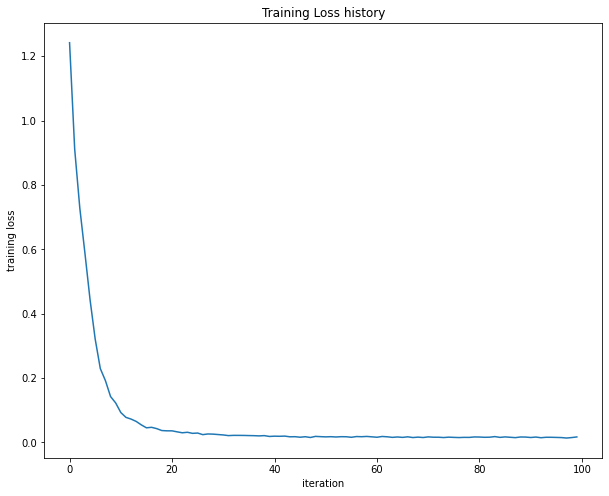

In [ ]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# Plota o histórico da função de perda
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Carregamento de dados
Agora que você testou uma rede de duas camadas passando pela verificação de gradientes e seu funcionado sobre o pequeno conjunto de dados, é hora de carregar os dados do **CIFAR-10 dataset** de modo que você possa usá-los no treinamento de um classificador sobre dados reais.

In [ ]:
from __future__ import print_function

from six.moves import cPickle as pickle
import numpy as np
import os
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Carrega CIFAR-10 dataset a partit do disco e realiza preprocessamento para preparar
    os dados para a rede neural de duas camadas. Estes são os mesmos passos usados para o modelo
    SVM, porém condensado em uma única função.  
    """
    # Carregga os dados CIFAR-10 brutos
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subdivide os dados em conjuntos
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test


# Usar a função definida acmina para obter os dados.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


## Visualizando amostras dos dados
Utilize a célula a seguir para visualizar algumas amostras das 10 classes de imagens da base `CIFAR-10`

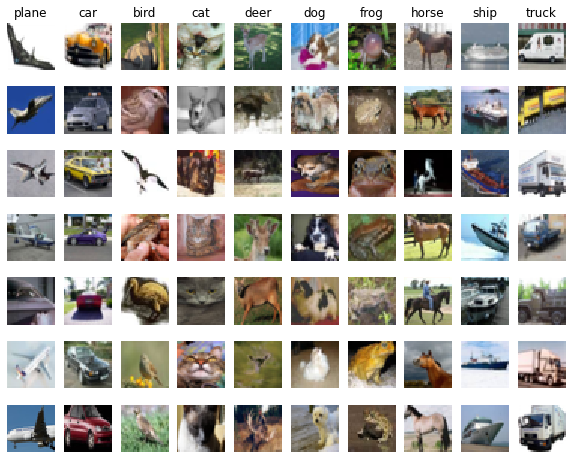

In [ ]:
# Visualizar alguns exemplos do dataset.
# São exibidos apenas 7 exemplos de imagens de treinamento de cada classe.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

## Normalização de dados
Conforme discutido em sala de aula é importante para facilitar o treinamento que seja feito algum tipo de tratamento dos dados. Neste caso, uma simples subtração de uma imagem média está sendo utilizada na célula a seguir, de modo a centralizar os dados em torno da origem do sistemas de coordenadas.

In [ ]:
# Normaliza os dados: subtrai a imagem média
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# Redimensiona as imagens de matrizes para vetores
X_train = X_train.reshape(49000, -1)
X_val = X_val.reshape(1000, -1)
X_test = X_test.reshape(1000, -1)

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Treinamento de uma Rede com Dados Reais
Para treinar sua rede, você deve usar **SGD**. Além disso, nesse processo a taxa de aprendizado será ajustada com um decaimento exponencial ao longo do processo de otimização, isto é, após cada época, a taxa de aprendizado é multiplicada pela taxa de decaimento (como esta última é menor que um, consequentemente a taxa de aprendizado é reduzida).

In [ ]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Treinamento da rede
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predição sobre o conjunto de validação
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302785
iteration 100 / 1000: loss 2.302120
iteration 200 / 1000: loss 2.296135
iteration 300 / 1000: loss 2.241802
iteration 400 / 1000: loss 2.159391
iteration 500 / 1000: loss 2.133832
iteration 600 / 1000: loss 2.103901
iteration 700 / 1000: loss 1.961585
iteration 800 / 1000: loss 2.019776
iteration 900 / 1000: loss 1.994777
Validation accuracy:  0.286


# Depuração do treinamento
Com os valores de parâmetros fornecidos acima, você deve ter obtido uma acurácia no conjunto de validação em torno de 0.29. O que não representa um resultado muito bom...

Uma estratégia para melhorar o entendimento (fornecer *insigths*) sobre o que pode estar errado é traçar os gráficos de evolução da função de perda e das acurácias de treinamento e validação ao longo do processo de otimização.

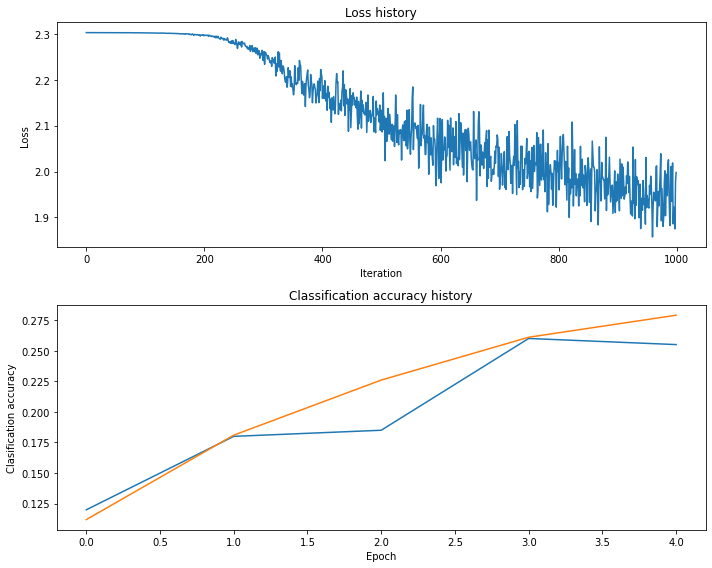

In [ ]:
# Plota a funcão de pedar e as acurácias de treinamento e validação
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.tight_layout()
plt.show()

Uma outra estratégia é construis uma visualização dos pesos que foram obtidos na primeira camada da rede. Por trás disto, está o fato de que na maioria das redes neurais treinadas sobre dados visuais, os pesos da primeira camada geralmente exibem algum tipo de estrutura visível.

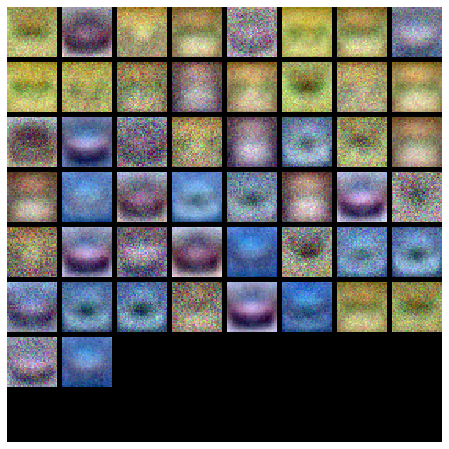

In [ ]:
from past.builtins import xrange

from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
  """
  Reshape a 4D tensor of image data to a grid for easy visualization.

  Inputs:
  - Xs: Data of shape (N, H, W, C)
  - ubound: Output grid will have values scaled to the range [0, ubound]
  - padding: The number of blank pixels between elements of the grid
  """
  (N, H, W, C) = Xs.shape
  grid_size = int(ceil(sqrt(N)))
  grid_height = H * grid_size + padding * (grid_size - 1)
  grid_width = W * grid_size + padding * (grid_size - 1)
  grid = np.zeros((grid_height, grid_width, C))
  next_idx = 0
  y0, y1 = 0, H
  for y in xrange(grid_size):
    x0, x1 = 0, W
    for x in xrange(grid_size):
      if next_idx < N:
        img = Xs[next_idx]
        low, high = np.min(img), np.max(img)
        grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
        # grid[y0:y1, x0:x1] = Xs[next_idx]
        next_idx += 1
      x0 += W + padding
      x1 += W + padding
    y0 += H + padding
    y1 += H + padding
  # grid_max = np.max(grid)
  # grid_min = np.min(grid)
  # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
  return grid

def vis_grid(Xs):
  """ visualize a grid of images """
  (N, H, W, C) = Xs.shape
  A = int(ceil(sqrt(N)))
  G = np.ones((A*H+A, A*W+A, C), Xs.dtype)
  G *= np.min(Xs)
  n = 0
  for y in range(A):
    for x in range(A):
      if n < N:
        G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = Xs[n,:,:,:]
        n += 1
  # normalize to [0,1]
  maxg = G.max()
  ming = G.min()
  G = (G - ming)/(maxg-ming)
  return G
  
def vis_nn(rows):
  """ visualize array of arrays of images """
  N = len(rows)
  D = len(rows[0])
  H,W,C = rows[0][0].shape
  Xs = rows[0][0]
  G = np.ones((N*H+N, D*W+D, C), Xs.dtype)
  for y in range(N):
    for x in range(D):
      G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = rows[y][x]
  # normalize to [0,1]
  maxg = G.max()
  ming = G.min()
  G = (G - ming)/(maxg-ming)
  return G

# Visualiza os pesos da primeira camada da rede

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# Ajuste de hiperparâmetros

**O que está errado?** Observando os gráficos e as visualizações acima, pode-se ver que a perda está reduzindo de forma *mais ou menos* linear, o que parece sugerir que a taxa de aprendizado pode estar muito baixa. Além disso, não há uma separação grande entre as acurácias de treinamento e validação, sugerindo que o modelo usado tem baixa capacidade e que talvez seu tamanho devesse ser aumentado. Por outro lado, com um modelo muito grande deve-se esperar observar mais *overfitting*, que se manifesta por meio de uma distância muita grande entre acurácias de treinamento e de validação.

**Ajuste**. Realizar o ajuste de hiperparâmetros e desenvolver uma nocão intuitiva de como eles afetam o resultado final é uma parte importatnte do uso de Redes Neurais. Dessa forma, deseja-se que você realize várias práticas envolvendo o ajuste de hiperparâmetros. A seguir, você deve realizar experimentos com diferentes valores para os hiperparâmetros incluindo: tamanho da camada escondida, taxa de aprendizado, taxa de decaimento, número de épocas de treinamento e regularização. 

**Resultados aproximados**. Você deve tentar alcançar uma acurácia de classificação (taxa de acerto) maior que 48% no conjunto de validação. (OBS: minha solução obteve uma acurácia acima de 52% no conjunto de validação!)

**Experimento**: O objetivo desse exercício é que você tente obter o melhor resultado sobre a base CIFAR-10, usando uma rede neural completamente conectada. Sinta-se livre para implementar quaisquer técnicas que desejar (p.ex., redução de dimensionalidade via PCA, *dropout*, ou outras estratégias ao otimizador, etc).

**OBS: Lembre-se de deixar documentado tudo que foi feito! Caso necessário, acrescente mais células a sua vontade.**

In [ ]:
best_net = None # Armazenar o melhor modelo encontrado nesse variável pois será 
                # usado no teste final (ver final desse notebook)

#################################################################################
# TODO: Ajustar hiperparâmetros usando o conjunto de validação. O melhor modelo #
# obtido ao longo do treinamento deve-se armazenado em best_net.                #
#                                                                               #
# Para auxiliar a depurar sua rede, pode ser interessante se utilizar de        #
# visualizações similares as usadas acima. Essas visualizações irão apresentar  #
# diferenças qualitativas significativas especialmente para redes com ajustes   #
# ruins.                                                                        #
#                                                                               #
# O ajuste fino de hiperparâmetros feito manualmente pode ser divertido, mas    #
# provavelmente você deverá considerar a possibilidade de escrever código que   #
# percorra todas as combinações possíveis de hiperparâmetros de forma a tornar  #
# automático o processo de busca (similar ao que foi feito nas atividades       #
# anteriores).                                                                  #
#################################################################################

pass

#################################################################################
#                              FIM DE SEU CÓDIGO                               #
#################################################################################

## Representando graficamente os resultados obtidos

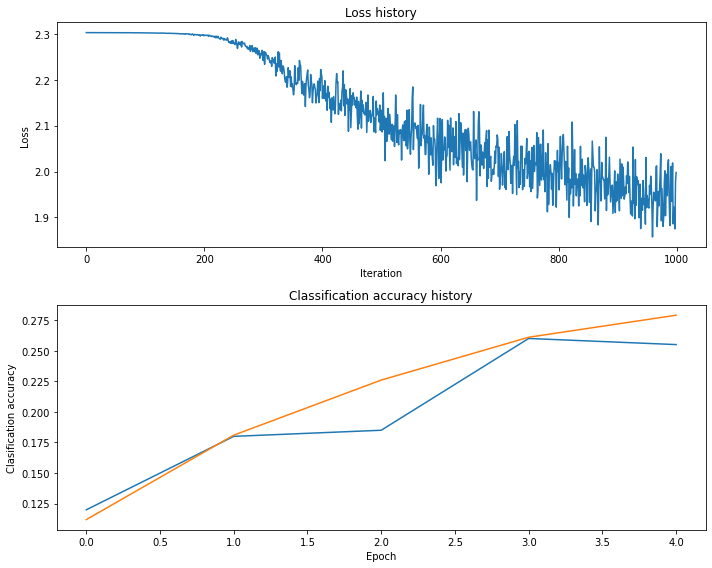

In [ ]:
# Plota a funcão de pedar e as acurácias de treinamento e validação
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.tight_layout()
plt.show()

## Visualizando pesos da primeira camada

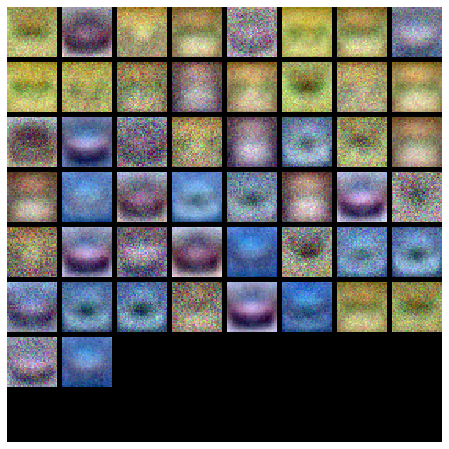

In [ ]:
# visualizar os pesos da primeira camada da melhor rede obtida
show_net_weights(net)

# Executar predições sobre o conjunto de teste
Quando você terminar com seus experimentos acima (**nunca antes!!!**), você deve avaliar sua rede final sobre o conjunto de teste e o resultado de acurácia (taxa de acerto) deve ser acima de 48%.

**Você deve tentar encontrar um resultado de acurácia igual ou acima de 52%.**

In [ ]:
test_acc = (net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.282
